In this practical session, you will implement different strategies to build a recommender system.

# Dataset



We will be utilizing 'The Movie Dataset' hosted on Kaggle, featuring comprehensive metadata for 45,000 movies listed in the Full MovieLens Dataset (accessible here: [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/)). The dataset encompasses films released up until July 2017 and includes a variety of data points such as cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, as well as TMDB vote counts and vote averages.

Additionally, this dataset encompasses 26 million ratings from 270,000 users across all 45,000 movies. These ratings, ranging from 1 to 5, are sourced directly from the official GroupLens website.

To access this dataset, a [Kaggle](https://www.kaggle.com/) account is required. After logging into Kaggle, navigate to your account settings and scroll to the API section to generate a new API token. This token will facilitate the direct download of the dataset via the Kaggle library in your notebook.

![Instructions for generating a Kaggle API token](https://drive.google.com/uc?export=view&id=1YcSTHD_FGrwDKaaLk6T9Gsdte8TKuPCt)

Now, you can proceed to install the Kaggle library in your notebook, which allows for the dataset to be downloaded directly.


Run the next cell to upload your token.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


We will begin by analyzing the metadata dataset, which includes comprehensive information about the movies.  
This dataset encompasses details such as movie titles, descriptions, genres, and even their average IMDb ratings.

In [3]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f movies_metadata.csv
!kaggle datasets download "rounakbanik/the-movies-dataset" -f ratings.csv
!unzip movies_metadata.csv.zip
!unzip ratings.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
100% 12.2M/12.2M [00:01<00:00, 14.2MB/s]
100% 12.2M/12.2M [00:01<00:00, 7.83MB/s]
Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 98% 167M/170M [00:08<00:00, 22.6MB/s]
100% 170M/170M [00:09<00:00, 19.8MB/s]
Archive:  movies_metadata.csv.zip
  inflating: movies_metadata.csv     
Archive:  ratings.csv.zip
  inflating: ratings.csv             


Use pandas to explore the `movies_metadata.csv` dataset.


In [4]:
import pandas as pd
metadata = pd.read_csv('movies_metadata.csv')
metadata.dropna(subset=['title'], inplace=True)
metadata['id'] = pd.to_numeric(metadata['id'])
metadata['genres'] = metadata['genres'].apply(lambda x: [i['name'] for i in eval(x)])
metadata = metadata[['id', 'title', 'genres', 'release_date', 'vote_average', 'vote_count']]
metadata.head(5)

<ipython-input-4-8e2a9fc35ff1>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('movies_metadata.csv')


id                        title                        genres  \
0    862                    Toy Story   [Animation, Comedy, Family]   
1   8844                      Jumanji  [Adventure, Fantasy, Family]   
2  15602             Grumpier Old Men             [Romance, Comedy]   
3  31357            Waiting to Exhale      [Comedy, Drama, Romance]   
4  11862  Father of the Bride Part II                      [Comedy]   

  release_date  vote_average  vote_count  
0   1995-10-30           7.7      5415.0  
1   1995-12-15           6.9      2413.0  
2   1995-12-22           6.5        92.0  
3   1995-12-22           6.1        34.0  
4   1995-02-10           5.7       173.0

Using the release date, create a new column called `year` and use seaborn to plot the number of movies per year.

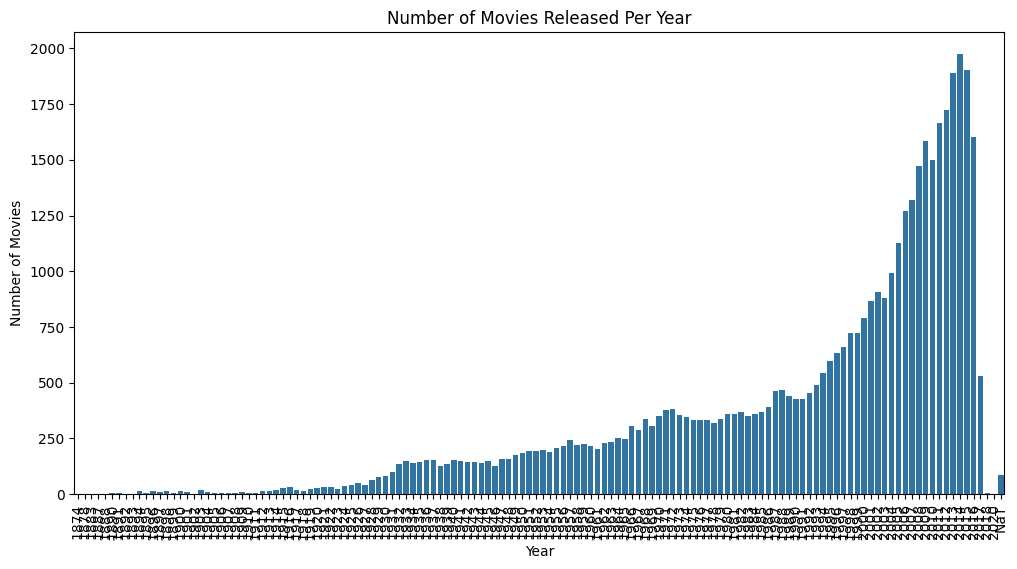

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
# Plot the number of movies per year
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='year', order=metadata['year'].value_counts().index.sort_values())
plt.xticks(rotation=90)
plt.title("Number of Movies Released Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()

# Recommendation by popularity

Let's start with a straightforward approach to generating recommendations by suggesting the top 5 movies based on their average score. However, it's worth noting that while average score is a useful metric, it may not always provide the most personalized recommendations, as individual preferences can vary widely.

In [6]:
top_movies = metadata.dropna(subset=['vote_average'])
# Sort movies by 'average_score' in descending order
top_movies = top_movies.sort_values(by='vote_average', ascending=False)

# Select the top 5 movies
top_5_movies = top_movies.head(5)

# Display the titles and scores of the top 5 movies
print("Top 5 Movies Based on Average Score:")
print(top_5_movies[['title', 'vote_average']])

Top 5 Movies Based on Average Score:
                                                   title  vote_average
11050                                      Blessed Event          10.0
37543         Portrait of a Young Man in Three Movements          10.0
36633                                             Avetik          10.0
33280  Dream Deceivers: The Story Behind James Vance ...          10.0
14536         Dinosaurs!  A Fun-Filled Trip Back In Time          10.0


Have you seen any of these movies?  
You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.
Use seaborn ```histplot``` method to plot the histogram of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another one for the remaining ones.

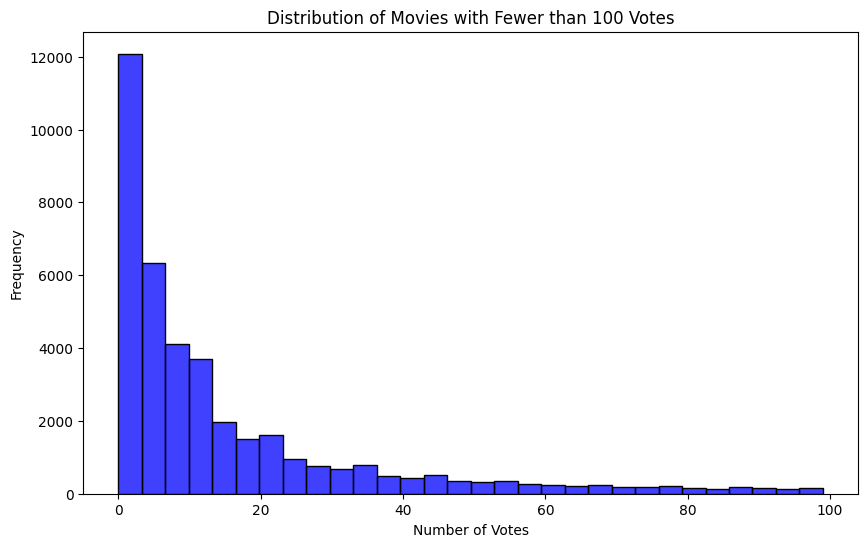

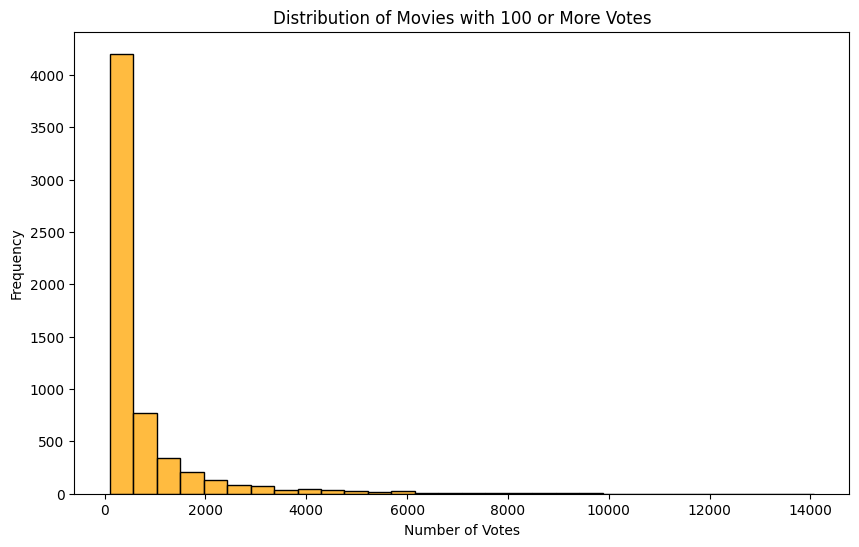

In [7]:
# Movies with fewer than 100 votes
low_vote_movies = metadata[metadata['vote_count'] < 100]

# Movies with 100 or more votes
high_vote_movies = metadata[metadata['vote_count'] >= 100]

# Plot histogram for movies with fewer than 100 votes
plt.figure(figsize=(10, 6))
sns.histplot(low_vote_movies['vote_count'], bins=30, kde=False, color='blue')
plt.title('Distribution of Movies with Fewer than 100 Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for movies with 100 or more votes
plt.figure(figsize=(10, 6))
sns.histplot(high_vote_movies['vote_count'], bins=30, kde=False, color='orange')
plt.title('Distribution of Movies with 100 or More Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

Try to visualize the best movies according to the average vote for movies that have at least 1000 votes.  
You should now know some of these movies now.


<ipython-input-8-78fc151e1fc3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, x='vote_average', y='title', palette='viridis')


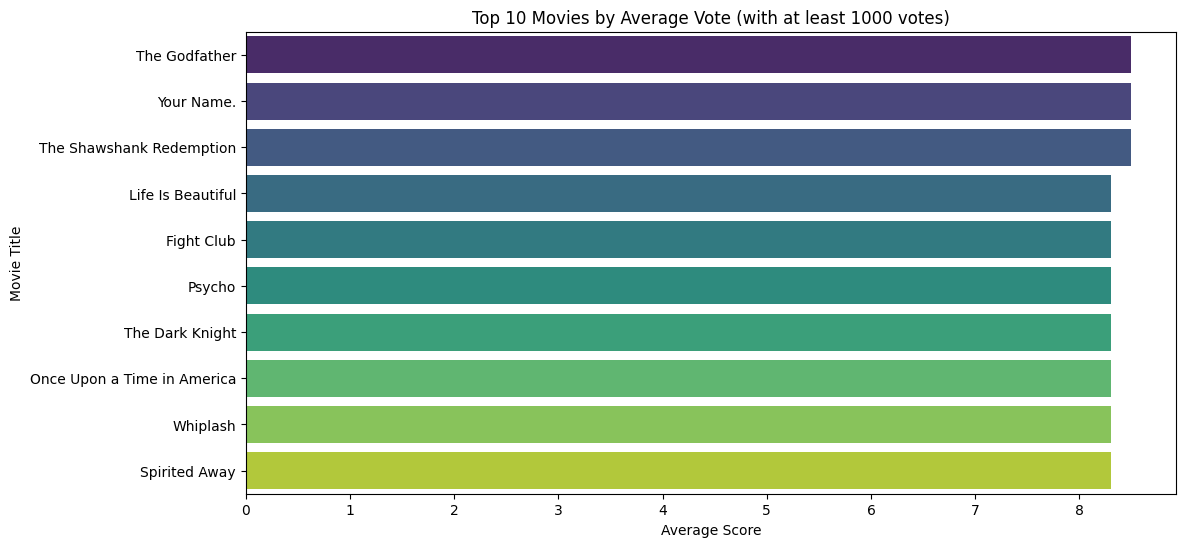

In [8]:
# Filter movies with at least 1000 votes
popular_movies = metadata[metadata['vote_count'] >= 1000]

# Sort by average vote in descending order
popular_movies_sorted = popular_movies.sort_values(by='vote_average', ascending=False)

# Select the top 10 movies
top_movies = popular_movies_sorted.head(10)

# Plot the top 10 movies
plt.figure(figsize=(12, 6))
sns.barplot(data=top_movies, x='vote_average', y='title', palette='viridis')
plt.title('Top 10 Movies by Average Vote (with at least 1000 votes)')
plt.xlabel('Average Score')
plt.ylabel('Movie Title')
plt.show()

## Best movies by IMDb score
IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online.
It might be considered as one of the most exhaustive databases on movies.
In addition, IMDb maintains a ranking of movies according to people's votes. To do so, it computes a score based on the average rating and the number of votes.
The formula they are using is described [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)  
Use this formula to compute the IMDb score for all movies and visualize the ones with the best scores. (You may use a smaller value for m, 500 for example)


In [9]:
m = 500  # Minimum number of votes
c = metadata['vote_average'].mean()  # Mean of vote averages

def imdb_score(row):
    v = row['vote_count']
    R = row['vote_average']
    if v >= m:
        return (v / (v + m) * R) + (m / (v + m) * c)
    else:
        return R  # Default to average score for movies with insufficient votes

# Apply the IMDb scoring formula
metadata['imdb_score'] = metadata.apply(imdb_score, axis=1)

# Sort movies by IMDb score and display top 10
top_imdb_movies = metadata.sort_values(by='imdb_score', ascending=False).head(10)

# Display the results
print("Top 10 Movies Based on IMDb Score:")
print(top_imdb_movies[['title', 'imdb_score', 'vote_average', 'vote_count']])


Top 10 Movies Based on IMDb Score:
                                       title  imdb_score  vote_average  \
27769                                    Pan        10.0          10.0   
23598                             Tall Story        10.0          10.0   
45362      The Many Faces of Christopher Lee        10.0          10.0   
45371  LEGO DC Super Hero Girls: Brain Drain        10.0          10.0   
2948                               Ten Benny        10.0          10.0   
39344                    Survive and Advance        10.0          10.0   
17106                                Macbeth        10.0          10.0   
27817                          Heavy Weather        10.0          10.0   
27814                             Kolka Cool        10.0          10.0   
22578                              Eggshells        10.0          10.0   

       vote_count  
27769         1.0  
23598         1.0  
45362         1.0  
45371         2.0  
2948          1.0  
39344         2.0  
17106     

What were the best movies in your birth year?

In [10]:
metadata[metadata['year'] == '2001']

id                                        title  \
3903    62677                                  Songcatcher   
3926     9989                                    Antitrust   
3927    18828                                  Double Take   
3928     9816                          Save the Last Dance   
3930     5955                                   The Pledge   
...       ...                                          ...   
44824   20755                         Air Bud 3: World Pup   
44826   12600  Pokémon 4Ever: Celebi - Voice of the Forest   
45027   51039                          Kites Over Helsinki   
45041   32593          Snow White: The Fairest of Them All   
45307  168819                                       Weiser   

                                                  genres release_date  \
3903                                      [Drama, Music]   2001-03-01   
3926                              [Action, Crime, Drama]   2001-01-12   
3927         [Adventure, Drama, Action, Comedy, Romance]   2001-01-12   
3928                     [Drama, Family, Romance, Music]   2001-01-12   
3930                   [Crime, Drama, Mystery, Thriller]   2001-01-09   
...                                                  ...          ...   
44824                            [Comedy, Drama, Family]   2001-06-29   
44826  [Adventure, Fantasy, Animation, Science Fictio...   2001-07-06   
45027                                                 []   2001-09-07   
45041             [Adventure, Family, Fantasy, TV Movie]   2001-10-28   
45307                                          [Mystery]   2001-01-18   

       vote_average  vote_count  year  imdb_score  
3903            5.6         9.0  2001         5.6  
3926            5.8       156.0  2001         5.8  
3927            5.5        24.0  2001         5.5  
3928            6.3       359.0  2001         6.3  
3930            6.6       221.0  2001         6.6  
...             ...         ...   ...         ...  
44824           4.5        35.0  2001         4.5  
44826           5.7        82.0  2001         5.7  
45027           8.0         1.0  2001         8.0  
45041           5.3        52.0  2001         5.3  
45307           5.8         4.0  2001         5.8  

[865 rows x 8 columns]

In [11]:
# Filter movies released in 2001
movies_2001 = metadata[metadata['year'] == '2001']

# Sort movies from 2001 by IMDb score in descending order
best_movies_2001 = movies_2001.sort_values(by='imdb_score', ascending=False).head(10)

# Display the top movies
print("Top Movies from 2001 Based on IMDb Score:")
print(best_movies_2001[['title', 'imdb_score', 'vote_average', 'vote_count']])

Top Movies from 2001 Based on IMDb Score:
                                    title  imdb_score  vote_average  \
30288                       Backyard Dogs        10.0          10.0   
20209                  Road to Redemption        10.0          10.0   
36207                              Aashiq        10.0          10.0   
41406                            Frontier         9.0           9.0   
29322                         Say Nothing         9.0           9.0   
19712  Lana Turner... a Daughter's Memoir         9.0           9.0   
43618                           Den radio         9.0           9.0   
28180                          Üvegtigris         8.5           8.5   
40209                       Figli – Hijos         8.3           8.3   
18270                             Angelus         8.3           8.3   

       vote_count  
30288         1.0  
20209         1.0  
36207         1.0  
41406         1.0  
29322         1.0  
19712         1.0  
43618         5.0  
28180        12.

One way to refine recommendations is by considering popularity and recommending products from the same category or genre. This approach can help ensure that the suggestions are not only highly rated but also aligned with the user's interests.  
The following code will create a data frame containing one-hot encoding of the movie's genre.
Use it to recommend the best movies according to the genre and the IMDB score (for example the best Horror movies)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(metadata['genres'].fillna('[]')),columns=mlb.classes_, index=metadata.index)
metadata = pd.concat([metadata.drop(columns=['genres']), genre_df], axis=1)
metadata.head()

id                        title release_date  vote_average  vote_count  \
0    862                    Toy Story   1995-10-30           7.7      5415.0   
1   8844                      Jumanji   1995-12-15           6.9      2413.0   
2  15602             Grumpier Old Men   1995-12-22           6.5        92.0   
3  31357            Waiting to Exhale   1995-12-22           6.1        34.0   
4  11862  Father of the Bride Part II   1995-02-10           5.7       173.0   

   year  imdb_score  Action  Adventure  Animation  ...  History  Horror  \
0  1995    7.524024       0          0          1  ...        0       0   
1  1995    6.679988       0          1          0  ...        0       0   
2  1995    6.500000       0          0          0  ...        0       0   
3  1995    6.100000       0          0          0  ...        0       0   
4  1995    5.700000       0          0          0  ...        0       0   

   Music  Mystery  Romance  Science Fiction  TV Movie  Thriller  War  Western  
0      0        0        0                0         0         0    0        0  
1      0        0        0                0         0         0    0        0  
2      0        0        1                0         0         0    0        0  
3      0        0        1                0         0         0    0        0  
4      0        0        0                0         0         0    0        0  

[5 rows x 27 columns]

Recommend some horror or comedy movies.

In [13]:
# Define a function to recommend the best movies by genre
def recommend_movies_by_genre(genre, top_n=10):
    if genre not in metadata.columns:
        print(f"Genre '{genre}' not found in dataset.")
        return None

    # Filter movies of the specified genre
    genre_movies = metadata[metadata[genre] == 1]

    # Sort movies by IMDb score
    top_genre_movies = genre_movies.sort_values(by='imdb_score', ascending=False).head(top_n)

    # Return the results
    return top_genre_movies[['title', 'imdb_score', 'vote_average', 'vote_count']]

# Recommend Horror movies
print("Top Horror Movies:")
horror_movies = recommend_movies_by_genre('Horror')
print(horror_movies)

# Recommend Comedy movies
print("\nTop Comedy Movies:")
comedy_movies = recommend_movies_by_genre('Comedy')
print(comedy_movies)

Top Horror Movies:
                         title  imdb_score  vote_average  vote_count
40442      Siccin 3: Cürmü Ask        10.0          10.0         2.0
42179             Patient Zero        10.0          10.0         2.0
24335     The Bride from Hades        10.0          10.0         1.0
44629              Tokyo Ghoul        10.0          10.0         1.0
19310         The Rites of May         9.5           9.5         1.0
42799             Zombie Pizza         9.3           9.3         2.0
41090  Killjoy's Psycho Circus         9.0           9.0         1.0
24856           Queens Of Evil         9.0           9.0         1.0
31076                Zapatlela         9.0           9.0         1.0
23251         Ghost Adventures         9.0           9.0         4.0

Top Comedy Movies:
                                               title  imdb_score  \
27814                                     Kolka Cool        10.0   
27817                                  Heavy Weather        10.0  

# Content based recommender systems


### Item description
An alternative approach to building a recommender system is to generate recommendations based on content characteristics. This method is particularly appealing when dealing with situations where there are limited user interactions or a scarcity of new items to recommend. It's highly probable that your catalog includes supplementary data related to the items. This additional information is typically curated manually and can contain valuable features for the development of a content-based recommender system.

In our specific case, we will obtain a dataset that includes keywords associated with the movies to facilitate this approach.

In [14]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f keywords.csv
!unzip keywords.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 72% 1.00M/1.39M [00:00<00:00, 1.07MB/s]
100% 1.39M/1.39M [00:01<00:00, 1.38MB/s]
Archive:  keywords.csv.zip
  inflating: keywords.csv            


In [15]:
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(lambda x: " ".join([i['name'] for i in eval(x)])).fillna('')
keywords.head()

id                                           keywords
0    862  jealousy toy boy friendship friends rivalry bo...
1   8844  board game disappearance based on children's b...
2  15602   fishing best friend duringcreditsstinger old men
3  31357  based on novel interracial relationship single...
4  11862  baby midlife crisis confidence aging daughter ...

These keywords can serve as excellent descriptors for our movies.  
To enable similarity calculations between movies, it's essential to represent them in a vectorized format.  
We will now create another dataframe containing all the movies attributes.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

mlb = CountVectorizer(max_features=400)
keywords_transformed = mlb.fit_transform(keywords['keywords'])
keywords_transformed = pd.DataFrame(keywords_transformed.toarray(), columns=mlb.get_feature_names_out(), index=keywords.index)
keywords = pd.concat([keywords.drop(columns=['keywords']), keywords_transformed], axis=1)
keywords.head()

id  1970s  3d  abuse  accident  addiction  adult  adultery  affair  \
0    862      0   0      0         0          0      0         0       0   
1   8844      0   0      0         0          0      0         0       0   
2  15602      0   0      0         0          0      0         0       0   
3  31357      0   0      0         0          0      0         0       0   
4  11862      0   0      0         0          0      0         0       0   

   africa  ...  wife  witch  woman  women  world  writer  york  young  youth  \
0       0  ...     0      0      0      0      0       0     0      0      0   
1       0  ...     0      0      0      0      0       0     0      0      0   
2       0  ...     0      0      0      0      0       0     0      0      0   
3       0  ...     0      0      0      0      0       0     0      0      0   
4       0  ...     0      0      0      0      0       0     0      0      0   

   zombie  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 401 columns]

We will proceed by constructing a dataframe in which each movie is depicted through its attribute vectors, encompassing keywords and genres.  
To optimize computational resources and reduce memory requirements, we will restrict our analysis to movies released after the year 2010.

In [17]:
subset = metadata[metadata['release_date'] > "2010"].reset_index(drop=True)

attributes_df = pd.merge(subset.drop(columns=['release_date', 'vote_average', 'vote_count', 'year',
       'imdb_score']), keywords, on='id')
attributes_df.head()

id                 title  Action  Adventure  Animation  Comedy  Crime  \
0   79782                Venice       0          0          0       0      0   
1  141210         The Sleepover       0          0          0       1      0   
2  143750     The Farmer's Wife       0          0          0       0      0   
3   84198  A Place at the Table       0          0          0       0      0   
4   84198  A Place at the Table       0          0          0       0      0   

   Documentary  Drama  Family  ...  wife  witch  woman  women  world  writer  \
0            0      1       0  ...     0      0      0      0      0       0   
1            0      0       0  ...     0      0      0      0      0       0   
2            0      1       0  ...     0      0      0      0      0       0   
3            1      0       0  ...     0      0      1      0      0       0   
4            1      0       0  ...     0      0      1      0      0       0   

   york  young  youth  zombie  
0     0      0      0       0  
1     0      0      0       0  
2     0      0      0       0  
3     0      0      0       0  
4     0      0      0       0  

[5 rows x 422 columns]

Now that you have a representation computed for each movie, you can calculate distances or similarities for movie pairs.  
Use scikit-learn 's [cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html) function, to compute the cosine similarity matrix of your dataframe.  

In [18]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(attributes_df.drop(columns=['id', 'title']))
print(cosine_sim)

[[0.         1.         0.5        ... 0.5        0.59175171 1.        ]
 [1.         0.         1.         ... 0.5        1.         1.        ]
 [0.5        1.         0.         ... 0.5        0.59175171 1.        ]
 ...
 [0.5        0.5        0.5        ... 0.         0.59175171 1.        ]
 [0.59175171 1.         0.59175171 ... 0.59175171 0.         1.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]]


Use the following function with your similarity matrix to recommend movies from another movie title.  
Try on several movies.

In [19]:
titles = attributes_df['title']
indices = pd.Series(attributes_df.index, index=attributes_df['title'])

def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]

  print(recos)

In [20]:
title = 'LEGO: The Adventures of Clutch Powers'
get_reco(title, cosine_sim)

original: LEGO: The Adventures of Clutch Powers
4380                                                Tarzan
11016                                               Trolls
7253     LEGO DC Comics Super Heroes: Justice League: A...
5129     LEGO DC Comics Super Heroes: Justice League vs...
11020    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
Name: title, dtype: object


In [21]:
title = 'Iron Man 2'
get_reco(title, cosine_sim)

original: Iron Man 2
4548                                          Ant-Man
6006        Iron Man & Captain America: Heroes United
3143    Avengers Confidential: Black Widow & Punisher
4554                                   Doctor Strange
2618                             Thor: The Dark World
Name: title, dtype: object


In [22]:
title = 'How to Train Your Dragon'
get_reco(title, cosine_sim)

original: How to Train Your Dragon
10712                             Over the Garden Wall
193      Legend of the Guardians: The Owls of Ga'Hoole
7484                        The Snow Queen 2: Refreeze
6780               Arthur 3: The War of the Two Worlds
6703                       Dragon Nest: Warriors' Dawn
Name: title, dtype: object


In [23]:
title = 'Alice in Wonderland'
get_reco(title, cosine_sim)

original: Alice in Wonderland
9770                      Alice Through the Looking Glass
297     The Chronicles of Narnia: The Voyage of the Da...
2343                       Percy Jackson: Sea of Monsters
2119                                                 Epic
5209                                                  Pan
Name: title, dtype: object


Let's free some memory in the Colab instance.

In [24]:
del(cosine_distances)
del(attributes_df)

### Images

Images are another type of content associated to products.  
It may not necessarily be relevant in the case of movies but let's do it anyway.  
We will now recommend movies according to their posters.  
First, we need to download another dataset.

In [25]:
!kaggle datasets download "ghrzarea/movielens-20m-posters-for-machine-learning"
!unzip movielens-20m-posters-for-machine-learning.zip

Streaming output truncated to the last 5000 lines.
  inflating: mlp-20m/MLP-20M/81566.jpg  
  inflating: mlp-20m/MLP-20M/81568.jpg  
  inflating: mlp-20m/MLP-20M/8157.jpg  
  inflating: mlp-20m/MLP-20M/81574.jpg  
  inflating: mlp-20m/MLP-20M/8158.jpg  
  inflating: mlp-20m/MLP-20M/81583.jpg  
  inflating: mlp-20m/MLP-20M/81585.jpg  
  inflating: mlp-20m/MLP-20M/81587.jpg  
  inflating: mlp-20m/MLP-20M/81589.jpg  
  inflating: mlp-20m/MLP-20M/81591.jpg  
  inflating: mlp-20m/MLP-20M/816.jpg  
  inflating: mlp-20m/MLP-20M/81610.jpg  
  inflating: mlp-20m/MLP-20M/81613.jpg  
  inflating: mlp-20m/MLP-20M/81615.jpg  
  inflating: mlp-20m/MLP-20M/81617.jpg  
  inflating: mlp-20m/MLP-20M/81621.jpg  
  inflating: mlp-20m/MLP-20M/81629.jpg  
  inflating: mlp-20m/MLP-20M/81631.jpg  
  inflating: mlp-20m/MLP-20M/81633.jpg  
  inflating: mlp-20m/MLP-20M/81637.jpg  
  inflating: mlp-20m/MLP-20M/81639.jpg  
  inflating: mlp-20m/MLP-20M/81641.jpg  
  inflating: mlp-20m/MLP-20M/81643.jpg  
  inflatin

The following code will help loading the data with Pytorch.

In [26]:
import torch
from torchvision import datasets

class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path



We will use a pre-trained network to extract the features from the posters.
Similar to what we did with the item descriptions, we will compute similarities between the movies according to these features.

The pre-trained model was trained with normalized images. Thus, we have to normalize our posters before feeding them to the network.
The following code instantiates a data loader with normalized images and provides a function to revert the normalization for visualization purposes.


In [28]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])
dataset = ImageAndPathsDataset('MLP-20M', transform)

dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

Here are some exemples of posters:

(-0.5, 1809.5, 453.5, -0.5)

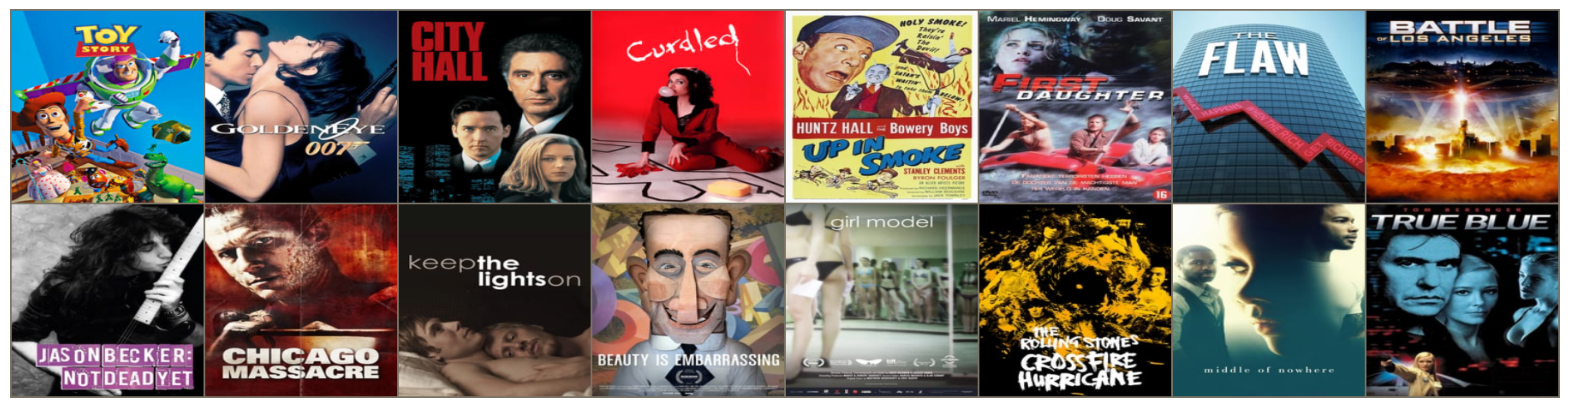

In [29]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Instantiate a pre-trained a mobilenet_v3_small model (documentation [here](https://pytorch.org/vision/stable/models.html))

In [30]:
import torchvision.models as models

# Instantiate the pre-trained MobileNetV3_Small model
mobilenet = models.mobilenet_v3_small(pretrained=True)

# Switch the model to evaluation mode
mobilenet.eval()

# Display the architecture of the model (optional)
print(mobilenet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 31.4MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Have a look to the model:

In [31]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

We will now crate a subset of this model to extract the features.
Use a Sequential model to get only the features followed by the avgpool layer of mobilnet and finish with a Flatten layer (```torch.nn.Flatten()```)


In [34]:
import torch.nn as nn
# Create a subset of the model
model = nn.Sequential(
    mobilenet.features,       # Feature extraction layers of MobileNet
    mobilenet.avgpool,        # Average pooling layer
    nn.Flatten()              # Flatten layer to produce a 1D vector
).cuda()  # Move to GPU if available

# Switch the model to evaluation mode
model.eval()



Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(

If your model is OK, it should predict 576-dimensional vectors.

In [35]:
import torch
x = torch.zeros(100, 3, 224,224).cuda()
y = model(x)
y.shape

torch.Size([100, 576])


We will proceed to establish a dataframe containing our extracted features, along with the file paths to the poster images..

In [36]:
import pandas as pd
from tqdm.notebook import tqdm

features_list = []
paths_list = []

for x, paths in tqdm(dataloader):
    with torch.no_grad():
        embeddings = model(x.cuda())
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

  0%|          | 0/211 [00:00<?, ?it/s]

features  \
0  [0.9991115, 0.019944973, 0.4069016, 0.66876864...   
1  [0.06494351, 0.29157645, 0.88163805, 0.3576982...   
2  [0.07715972, 0.024350438, -0.09276492, 0.41985...   
3  [0.22735633, 0.481557, 0.15827999, -0.09540324...   
4  [0.13140865, -0.09203931, 0.11884755, 0.196281...   

                         path  
0       MLP-20M/MLP-20M/1.jpg  
1      MLP-20M/MLP-20M/10.jpg  
2     MLP-20M/MLP-20M/100.jpg  
3    MLP-20M/MLP-20M/1000.jpg  
4  MLP-20M/MLP-20M/100003.jpg

We will now extract all the features into a numpy array that will be used to compute the similarity matrix.

In [37]:
import numpy as np
features = np.vstack(features_list)
features.shape

(26938, 576)

Now compute the cosine similarities between the embeddings of your movies.

In [38]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(features)
cosine_sim.shape

(26938, 26938)

The ```plot_image``` function  displays a poster according to it's path.  
Fill the ```plot_images``` function to plot a series of posters from a list of paths.

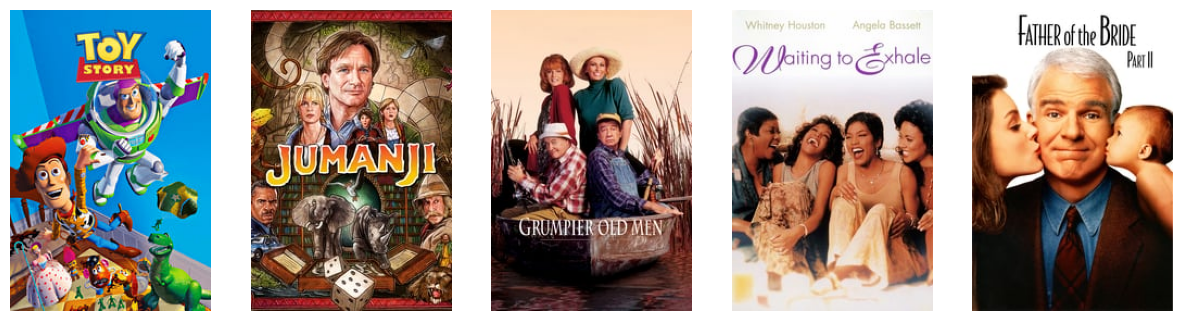

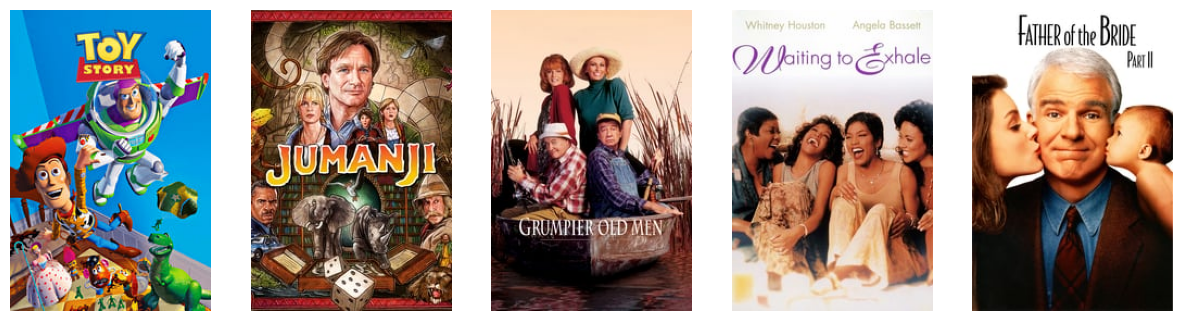

In [39]:
import matplotlib.image as mpimg

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
    plt.figure(figsize=(15, 5))  # Set the figure size
    for i, path in enumerate(paths_list):
        plt.subplot(1, len(paths_list), i + 1)  # Create a subplot for each image
        plot_image(path)
    plt.show()  # Display all images

# Example usage
plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg',
             'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg',
             'MLP-20M/MLP-20M/5.jpg'])


plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg', 'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg', 'MLP-20M/MLP-20M/5.jpg'])

Fill the following code to implement a function that plots the top 5 recommendations for a movie according to its index.

Original Movie:


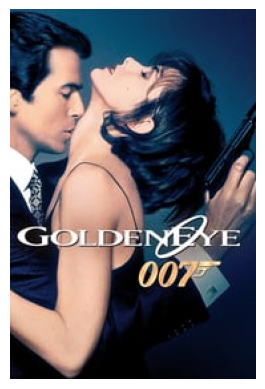

Recommended Movies:


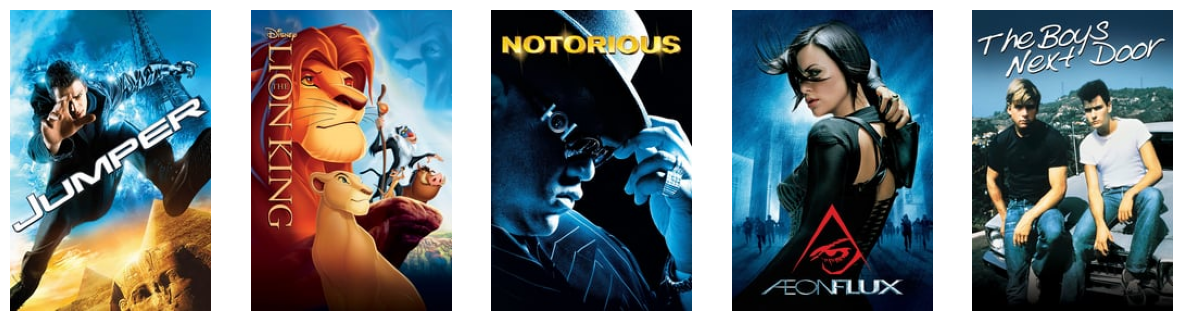

In [50]:

# Function to plot recommendations for a movie
def plot_reco(idx, sim_matrix):
    # Display the original movie poster
    print("Original Movie:")
    plot_image(df['path'][idx])
    plt.show()

    # Get the indices of the most similar movies
    similarity_scores = sim_matrix[idx].argsort()
    recos = similarity_scores[1:6]

    # Retrieve the paths of the recommended posters
    reco_posters = df['path'].iloc[recos].tolist()

    # Display the recommended posters
    print("Recommended Movies:")
    plot_images(reco_posters)

# Example usage
idx = 1 # Change the index to test with different movies
plot_reco(idx, cosine_sim)

Try with different movie indexes, you will be surprised by the lack of originality of the poster designers!  
Look at [this post](https://thechive.com/2020/01/20/all-movie-posters-look-the-same-what-the-hell-is-this-sht-20-photos/) to convince yourself.

## Vector databases  

Computing the similarity matrix is a very expensive operation in terms of memory and computation time that scales quadratically with the number of items.  It is also not very practical to store this matrix in a database.  
Vector databases offer a suite of advantages tailored to the needs of modern data analytics and machine learning applications. At their core, they specialize in handling high-dimensional data, allowing for efficient similarity searches—something traditional databases struggle with. This makes them invaluable for tasks like recommendation systems, image searches, and semantic text retrieval. Beyond search efficiency, vector databases are designed for scalability, capable of handling billions of vectors without a hitch. Furthermore, they often come with built-in mechanisms for distributed storage and computation, ensuring data resilience and fast query speeds even as data volumes grow. In essence, vector databases are the backbone that empowers many of the AI-driven solutions we see today.  
For our current session, we're aiming for simplicity and efficiency. Many of the standard vector databases, like [Milvus](https://milvus.io/) or [Weaviate](https://weaviate.io/), require their own dedicated installations and often need to run on separate servers or containers.  
This can introduce added complexity. Instead, we're turning to [Annoy](https://github.com/spotify/annoy) a straightforward library developped by Spotify that lets us perform efficient neighbor searches without the installation and server overhead. While Annoy is great for our present needs, do keep in mind that in larger, production scenarios, the capabilities of a dedicated vector database could be invaluable.

In [51]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550733 sha256=7fa09c617b1b4cae610f0252c5d31a6729d3527f3cb496bfd8884287c094a15d
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


We will thus use the annoy library to create a vector database with our features.  
In our case the database will be a simple file on the disk that we will load in memory when needed.
To create the database, we will use an AnnoyIndex with the same dimensionality as our features and a metric to compute the distance between vectors.  
Here we will use the cosine distance and set the database vector size to 576 (the size of our features).

In [52]:
from annoy import AnnoyIndex

dim = 576
annoy_index = AnnoyIndex(dim, 'angular')

We will now fill the database with our features as indexed vectors.

In [54]:
for i, embedding in enumerate(features_list):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

Exception: You can't build a built index

The `annoy_index.build(10)` command builds the underlying data structures required for Annoy to perform its approximate nearest neighbor searches. Specifically, the number 10 indicates that Annoy should construct 10 trees. Building multiple trees helps improve the accuracy of the search at the expense of using more memory. In essence, this command is preparing Annoy to efficiently handle future queries.

Vector databases excel at efficient similarity searches due to their foundational design principles. Traditional databases rely on exact matches or predefined indices to retrieve data. In contrast, vector databases operate in the realm of high-dimensional vector spaces. Here, data points (or vectors) that are semantically or contextually similar are often closer in distance. By leveraging algorithms optimized for these spaces, like approximate nearest neighbor (ANN) searches, vector databases quickly identify data points that lie near a query point. This spatial awareness enables them to bypass exhaustive scans and zero in on relevant results, making similarity searches both rapid and precise.
Thus querying the database for the most similar items to a given item is a very fast operation.  
Complete the following function to retrieve the most similar items to a given item.

In [55]:
def search(query_vector, k=5):
    # Get the indices of the top-k most similar items
    indices = annoy_index.get_nns_by_vector(query_vector, k, include_distances=False)

    # Retrieve the paths (or any associated metadata) for the retrieved indices
    paths = df['path'].iloc[indices].tolist()

    return paths


Use this function to plot the top-k recommendations for a movie.

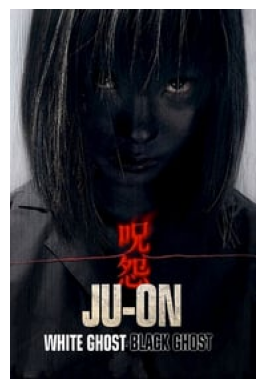

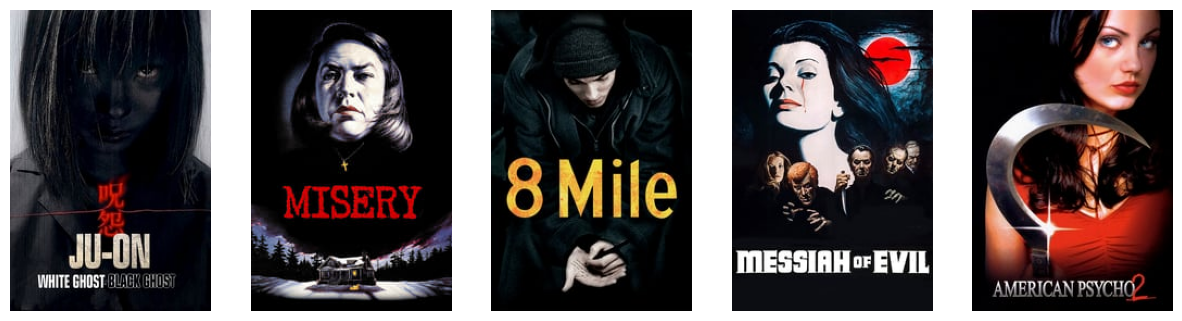

In [56]:
index = 600
plot_image(df.path[index])
query_vector = df.features[index]
result = search(query_vector)
plot_images(result)

Save you database, you will need it for your project.

In [57]:
annoy_index.save('rec_imdb.ann')

True

# Collaborative filtering

### Item-Item

Item-item collaborative filtering, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings.
For sake of simplicity, in this practical session, we will only focus on item-item similarity methods.
If you have time, feel free to try an user-item approach. The following [blog post](https://notebook.community/saksham/recommender-systems/Collaborative%20Filtering) may help you to do it.

We will use another dataset containing the ratings of several users on movies.

In [58]:
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv

--2024-11-21 08:34:18--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494431 (483K) [text/plain]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 482.84K  --.-KB/s    in 0.005s  

2024-11-21 08:34:19 (93.1 MB/s) - ‘movies.csv’ saved [494431/494431]

--2024-11-21 08:34:19--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [59]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.rename(columns={'movieId':'id'})
ratings['id'] = pd.to_numeric(ratings['id'])
ratings = pd.merge(ratings, metadata[['title', 'id']], on='id')[['userId', 'id', 'rating', 'title']]
ratings.head()

userId    id  rating                 title
0       1   110     1.0     Three Colors: Red
1       1   147     4.5         The 400 Blows
2       1   858     5.0  Sleepless in Seattle
3       1  1246     5.0          Rocky Balboa
4       1  1968     4.0         Fools Rush In

In [60]:
ratings.shape

(11437637, 4)

This dataset is a bit huge and may slow down futur computations. Moreover collaborative filtering kind of suffers from products or user with few ratings.
We will only focus on the 100 movies with the most ratings and the users with the highest number of ratings.

In [61]:
# filter movies
ratings['count'] = ratings.groupby('id').transform('count')['userId']
movieId = ratings.drop_duplicates('id').sort_values(
    'count', ascending=False).iloc[:200]['id']
ratings = ratings[ratings['id'].isin(movieId)].reset_index(drop=True)

#filter users
ratings['count'] = ratings.groupby('userId').transform('count')['id']
userId = ratings.drop_duplicates('userId').sort_values(
    'count', ascending=False).iloc[:20001]['userId']
ratings = ratings[ratings['userId'].isin(userId)].reset_index(drop=True)

ratings.shape

(1961101, 5)

In [62]:
ratings.head()

userId  id  rating               title  count
0      24   2     3.0               Ariel     99
1      24   6     4.0      Judgment Night     99
2      24  16     3.0  Dancer in the Dark     99
3      24  17     3.0            The Dark     99
4      24  21     4.0  The Endless Summer     99

In [63]:
ratings.title.unique()[:100]

array(['Ariel', 'Judgment Night', 'Dancer in the Dark', 'The Dark',
       'The Endless Summer', 'Jarhead', '2001: A Space Odyssey',
       'Run Lola Run', 'Three Colors: Red', 'Scarface', 'Stand by Me',
       'The 39 Steps', 'Contempt', 'A River Runs Through It',
       'Terminator 3: Rise of the Machines', 'The Science of Sleep',
       'Grbavica: The Land of My Dreams', 'The Million Dollar Hotel',
       'Monsieur Ibrahim', 'Cockles and Muscles',
       'A Nightmare on Elm Street', 'Aliens vs Predator: Requiem',
       'Romeo + Juliet', 'Sissi', 'Monsoon Wedding', 'The Green Mile',
       'Love Actually', 'Once Were Warriors',
       'The Man with the Golden Arm', 'Dogville', 'Big Fish',
       'Silent Hill', 'The Hours', 'The Conversation', 'Solaris',
       'To Kill a Mockingbird', 'Titanic', 'Men in Black II',
       'Beauty and the Beast', "Monsieur  Hulot's Holiday",
       'Mrs. Doubtfire', 'M', 'Sleepless in Seattle', 'Dawn of the Dead',
       'Arlington Road', 'Point Break

Now, we need to build a pivot table with user in lines, movies in columns and ratings as values.  
Use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) method to create this pivot table.

In [65]:
# Drop duplicate entries by keeping the first occurrence
ratings_deduplicated = ratings.drop_duplicates(subset=['userId', 'title'])

# Create the pivot table from the deduplicated ratings
pivot = ratings_deduplicated.pivot(index='userId', columns='title', values='rating')

# Display the first 100 rows of the pivot table
print(pivot.head(100))


title   20,000 Leagues Under the Sea  2001: A Space Odyssey  48 Hrs.  \
userId                                                                 
24                               NaN                    2.0      NaN   
34                               2.5                    NaN      3.5   
46                               2.0                    NaN      4.5   
49                               4.0                    NaN      NaN   
62                               NaN                    3.5      4.5   
...                              ...                    ...      ...   
1136                             NaN                    NaN      5.0   
1145                             NaN                    NaN      3.0   
1149                             NaN                    NaN      4.0   
1155                             NaN                    NaN      3.0   
1156                             NaN                    NaN      5.0   

title   5 Card Stud  A Brief History of Time  A Clockwork Orang

With this pivot table, it is now easy to compute the similarity between movies.
Indeed each movie can be represented by a vector of the users' ratings.
Instead of using a cosine similarity distance as we did earlier in the notebook, we will use the Pearson correlation score since it is already implemented in Pandas.
The pivot table has a method [```corrwith```](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html) that will return the Pairwise correlation score of one entry with all entries of the table.

In [66]:
movie_vector = pivot["Titanic"]
similarity = pivot.corrwith(movie_vector)


Sort the produced results to get the best recommendations to "Titanic".
You may also try with different movies.

## Matrix factorization
Matrix factorization is certainly one of the most efficient way to build a recomender system. I really encourage you to have a look to [this article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) presenting the matrix factorization techniques used in recommender systems.

The idea is pretty simple, it consists in factorizing the ratings matrix $R$ into the product of a user embedding matrix $U$ and an item embedding matrix $V$, such that $R \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Where
- $N$ is the number of users,
- $M$ is the number of items,
- $R_{ij}$ is the rating of the $j$th item by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing item $j$,


One these emmbeding matrices are built, predicting the rating of an user $i$ for an item $j$ consists in computing the dot product $\langle U_i, V_j \rangle$.

### Using surpise

![](https://drive.google.com/uc?export=view&id=1dh2RJ95F0j-rZyuf59G35239B42veAWD)

We will begin by using the famous Singular Value Decomposition method.
Several libraries implement this algorithm.
In this session, we will be using [Surprise](http://surpriselib.com/).
Surprise is a recommender system library implemented in Python.
It was actually developed by [Nicolas Hug](http://nicolas-hug.com/about) an INSA Toulouse Alumni!

In [67]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=8bb886c8fddca6527daac9ec5af0b9c1847c2cab047332cfb94db9d1a3248bdf
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Surprise implements the SVD algorithm.  Help yourself with [the doc](https://surprise.readthedocs.io/en/stable/getting_started.html) to train an SVD model on the rating dataset.

In [68]:
#Creating a train and a test set
testset = ratings.sample(frac=0.1, replace=False)
trainset = ratings[~ratings.index.isin(testset.index)]

assert set(testset.userId.unique()).issubset(trainset.userId.unique())
assert set(testset.id.unique()).issubset(trainset.id.unique())

In [69]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [70]:
# Define the Reader object with the rating scale
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load the dataset from the DataFrame
data = Dataset.load_from_df(ratings[['userId', 'id', 'rating']].fillna(0), reader)

# Initialize the SVD model
svd = SVD()

# Run 5-fold cross-validation and print results
cross_validation_results = cross_validate(svd, data, cv=5, verbose=True)

# Print summary of the results
print("\nCross-validation results:")
print(cross_validation_results)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7567  0.7554  0.7560  0.7573  0.7564  0.7564  0.0006  
MAE (testset)     0.5763  0.5761  0.5762  0.5773  0.5766  0.5765  0.0004  
Fit time          24.23   25.14   30.83   25.83   24.68   26.14   2.40    
Test time         4.75    4.95    3.36    4.00    4.87    4.38    0.61    

Cross-validation results:
{'test_rmse': array([0.75667136, 0.75539266, 0.75598638, 0.75732032, 0.75641541]), 'test_mae': array([0.57634716, 0.57607885, 0.57616363, 0.57731045, 0.57662106]), 'fit_time': (24.228204250335693, 25.135348320007324, 30.831913232803345, 25.831134557724, 24.680294275283813), 'test_time': (4.748009920120239, 4.945894241333008, 3.357102870941162, 3.9988350868225098, 4.865558385848999)}


In [71]:
#full dataset training
svd = SVD()
s_trainset = data.build_full_trainset()
svd.fit(s_trainset)

Let us look some ratings for one user in the test dataset.

In [72]:
testset[testset['userId'] == 24]

userId    id  rating                        title  count
50      24  1247     5.0            The Good Shepherd     99
70      24  2000     4.0    Aguirre: The Wrath of God     99
3       24    17     3.0                     The Dark     99
32      24   590     3.0                    The Hours     99
0       24     2     3.0                        Ariel     99
38      24   648     3.0         Beauty and the Beast     99
37      24   608     5.0              Men in Black II     99
77      24  2115     4.0                 Light of Day     99
62      24  1653     4.0       The Motorcycle Diaries     99
98      24  4034     5.0            That Man from Rio     99
4       24    21     4.0           The Endless Summer     99
21      24   440     2.0  Aliens vs Predator: Requiem     99
51      24  1259     5.0           Notes on a Scandal     99

What would your model predict for these exemples?

In [73]:
# Example user ID and item ID
uid = 24  # User ID
iid = 2   # Replace with the actual item ID for prediction

# Predict the rating for the user and item
prediction = svd.predict(uid, iid)

# Display the prediction result
print(f"Prediction for user {uid} and item {iid}:")
print(f"Predicted rating: {prediction.est}")
print(f"Actual details: {prediction}")


Prediction for user 24 and item 2:
Predicted rating: 2.9386256697943702
Actual details: user: 24         item: 2          r_ui = None   est = 2.94   {'was_impossible': False}


Write a code to recommend 5 movies to an user.

### Using gradient descent
Another way to compute the matrix factorization consists in using gradient descent to minimize $\text{MSE}(R, UV^\top)$ where:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

We will now implement our own matrix factorization algorith using Pytorch.  
To do so we first need to convert our ratings datasets in Pytorch datasets.

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.userId.unique()
item_list = trainset.id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = user2id[self.df['userId'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Datset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

These dataloader will provide mini-batches of tuples <user, movie, rating>.
We will use a special type of Pytorch layers call [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
These layers will create a mapping between an index and a vector representation.
In our case they will provide vector representations of our users and items.
We will train the matrix factorization model to minimize the prediction error between a rating and the dot product of an user embedding with a movie embedding.
![](https://drive.google.com/uc?export=view&id=1wSQbcSN_I28mF74-wnb8_qjAzRH9YDjA)

Complete the following code to implement the ```MatrixFactorization``` class in Pytorch.

In [75]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        return torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1)
        #return (self.user_embeddings(user)*self.item_embeddings(item)).sum(1)

Complete the training method that we will use to train the network.

In [76]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean

def train(model, optimizer, trainloader, epochs=30):
    # Define the loss function (Mean Squared Error)
    criterion = nn.MSELoss(reduction='mean')

    # Create a tqdm progress bar
    t = tqdm(range(epochs))

    for epoch in t:
        total = 0
        train_loss = []

        for users, items, r in trainloader:
            # Move data to GPU if available
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5  # Normalize ratings to the range [0, 1]
            r = r.unsqueeze(1)  # Add a dimension for compatibility

            # Forward pass
            y_hat = model(users, items)  # Predicted ratings
            y_hat = y_hat.unsqueeze(1)  # Ensure the same shape as `r`

            # Compute loss
            loss = criterion(y_hat, r)
            train_loss.append(loss.item())

            # Backward pass
            optimizer.zero_grad()  # Clear gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            total += r.size(0)

        # Update progress bar with the average loss
        t.set_description(f"loss: {mean(train_loss):.4f}")


We now have everything to train our model.
Train your model for 5 to 10 epochs.

In [77]:
n_user = trainset.userId.nunique()
n_items = trainset.id.nunique()
model = MatrixFactorization(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Complete the following code to evaluate your model.

In [78]:
import math
import torch

def test(model, testloader):
    running_mae = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        total = 0
        for users, items, r in testloader:
            # Move inputs and targets to GPU
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5  # Normalize ratings to the range [0, 1]

            # Get predictions from the model
            y_hat = model(users, items)

            # Compute absolute error
            error = torch.abs(y_hat - y).sum()  # Sum of absolute errors for the batch

            # Accumulate error
            running_mae += error
            total += y.size(0)  # Accumulate total number of samples

    # Compute Mean Absolute Error (MAE)
    mae = running_mae / total
    return mae * 5  # Scale MAE back to the original rating range


test(model, testloader)

tensor(0.6591, device='cuda:0')

Try to compare the predictions of your model with actual ratings.

In [79]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([4.0000, 4.5000, 3.5000, 3.5000, 3.5000, 4.0000, 4.0000, 4.0000, 4.5000,
        4.0000], device='cuda:0')
predictions: tensor([4.1635, 4.1078, 3.8353, 3.8387, 3.6012, 4.2343, 4.3984, 3.5466, 3.1773,
        4.0300], device='cuda:0')


We just trained a matrix factorization algorithm using Pytorch.
In this setting, the final prediction was made with the dot product of our embeddings.
Actually with a minimal modification of the Class, we could create a full neural network.
If we replace the dot product with a fully-connected network, we would actually have an end-to-end neural network able to predict the ratings of our users.
![](https://drive.google.com/uc?export=view&id=1THBMB-Z3db0Rn0dyYYWhN98AHcYEM-nT)  
This approach is called Neural Collaborative Filtering and is presented in this [paper](https://arxiv.org/pdf/1708.05031.pdf).
Try to fill in the following code to create an NCF network.



In [80]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        # Embedding layers for users and items
        self.user_embeddings = nn.Embedding(n_users, n_factors)
        self.item_embeddings = nn.Embedding(n_items, n_factors)

        # MLP predictor with fully connected layers
        self.predictor = nn.Sequential(
            nn.Linear(n_factors * 2, 128),  # Input size is 2*n_factors due to concatenation
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid to produce output in the range [0, 1]
        )

    def forward(self, user, item):
        # Get the embeddings for users and items
        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concatenate the two embedding layers along the last dimension
        z = torch.cat([u, i], dim=-1)

        # Pass the concatenated embeddings through the MLP predictor
        return self.predictor(z)

Train your NCF network on the train dataset and test it on the test dataset.

In [81]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([127, 1])) that is different to the input size (torch.Size([127, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [82]:
test(model, testloader)

tensor(51.0996, device='cuda:0')

In [83]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([4.0000, 4.5000, 3.5000, 3.5000, 3.5000, 4.0000, 4.0000, 4.0000, 4.5000,
        4.0000], device='cuda:0')
predictions: tensor([3.5808, 3.5709, 3.5753, 3.5712, 3.5770, 3.5732, 3.5734, 3.5743, 3.5746,
        3.5734], device='cuda:0')


### Implicit feedback with pytorch

In this practical session, we only worked with explicit feedbacks (ratings).
Sometimes you do not have access to such quantitative feedback and have to deal with implicit feedback.
An implicit feedback is a user's qualitative interaction with an item, such as clicking on an item (positive feedback) or stopping watching a video (negative feedback).
If you are interested in neural collaborative filtering in the case of implicit feedback, I recommend you look at this [excellent tutorial](https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html).